##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Basic text classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates text classification starting from plain text files stored on disk. You'll train a binary classifier to perform sentiment analysis on an IMDB dataset. At the end of the notebook, there is an exercise for you to try, in which you'll train a multiclass classifier to predict the tag for a programming question on Stack Overflow.


In [3]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [4]:
print(tf.__version__)

2.3.0


## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews.


### Download and explore the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.

In [5]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

    8192/84125825 [..............................] - ETA: 23:52

   24576/84125825 [..............................] - ETA: 15:56

   57344/84125825 [..............................] - ETA: 10:14

   90112/84125825 [..............................] - ETA: 8:41 

  139264/84125825 [..............................] - ETA: 7:01

  188416/84125825 [..............................] - ETA: 6:13

  253952/84125825 [..............................] - ETA: 5:23

  319488/84125825 [..............................] - ETA: 4:53

  417792/84125825 [..............................] - ETA: 4:12

  516096/84125825 [..............................] - ETA: 3:46

  647168/84125825 [..............................] - ETA: 3:18

  811008/84125825 [..............................] - ETA: 2:52

 1007616/84125825 [..............................] - ETA: 2:30

 1220608/84125825 [..............................] - ETA: 2:13

 1482752/84125825 [..............................] - ETA: 1:57

 1777664/84125825 [..............................] - ETA: 1:43

 2170880/84125825 [..............................] - ETA: 1:29

 2613248/84125825 [..............................] - ETA: 1:18

 3137536/84125825 [>.............................] - ETA: 1:06

 3153920/84125825 [>.............................] - ETA: 1:08

 3760128/84125825 [>.............................] - ETA: 59s 

 4497408/84125825 [>.............................] - ETA: 52s

 5382144/84125825 [>.............................] - ETA: 45s

 6463488/84125825 [=>............................] - ETA: 38s

 7757824/84125825 [=>............................] - ETA: 33s

 9330688/84125825 [==>...........................] - ETA: 28s

11198464/84125825 [==>...........................] - ETA: 23s

13361152/84125825 [===>..........................] - ETA: 20s

15769600/84125825 [====>.........................] - ETA: 17s

18391040/84125825 [=====>........................] - ETA: 14s

21258240/84125825 [======>.......................] - ETA: 12s

24322048/84125825 [=======>......................] - ETA: 10s

24338432/84125825 [=======>......................] - ETA: 10s

27467776/84125825 [========>.....................] - ETA: 9s 

30597120/84125825 [=========>....................] - ETA: 8s

33644544/84125825 [==========>...................] - ETA: 7s

33742848/84125825 [===========>..................] - ETA: 7s

36233216/84125825 [===========>..................] - ETA: 6s

36806656/84125825 [============>.................] - ETA: 6s

38871040/84125825 [============>.................] - ETA: 5s

39952384/84125825 [=============>................] - ETA: 5s

41312256/84125825 [=============>................] - ETA: 5s

43081728/84125825 [==============>...............] - ETA: 4s

43950080/84125825 [==============>...............] - ETA: 4s

46211072/84125825 [===============>..............] - ETA: 4s

47095808/84125825 [===============>..............] - ETA: 4s

49340416/84125825 [================>.............] - ETA: 3s

50208768/84125825 [================>.............] - ETA: 3s

52486144/84125825 [=================>............] - ETA: 3s

53321728/84125825 [==================>...........] - ETA: 3s

55615488/84125825 [==================>...........] - ETA: 2s

56434688/84125825 [===================>..........] - ETA: 2s

58744832/84125825 [===================>..........] - ETA: 2s

59547648/84125825 [====================>.........] - ETA: 2s

61874176/84125825 [=====================>........] - ETA: 2s

62693376/84125825 [=====================>........] - ETA: 2s

65019904/84125825 [======================>.......] - ETA: 1s

65839104/84125825 [======================>.......] - ETA: 1s

68149248/84125825 [=======================>......] - ETA: 1s

68935680/84125825 [=======================>......] - ETA: 1s

71245824/84125825 [========================>.....] - ETA: 1s

72048640/84125825 [========================>.....] - ETA: 1s

73834496/84125825 [=========================>....] - ETA: 0s

75161600/84125825 [=========================>....] - ETA: 0s

76292096/84125825 [==========================>...] - ETA: 0s

78274560/84125825 [==========================>...] - ETA: 0s

78946304/84125825 [===========================>..] - ETA: 0s

81387520/84125825 [============================>.] - ETA: 0s

81600512/84125825 [============================>.] - ETA: 0s

84131840/84125825 [==============================] - 7s 0us/step


In [6]:
os.listdir(dataset_dir)

['imdb.vocab', 'train', 'test', 'README', 'imdbEr.txt']

In [7]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_pos.txt',
 'neg',
 'labeledBow.feat',
 'pos',
 'urls_neg.txt',
 'unsup',
 'unsupBow.feat',
 'urls_unsup.txt']

The `aclImdb/train/pos` and `aclImdb/train/neg` directories contain many text files, each of which is a single movie review. Let's take a look at one of them.

In [8]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


### Load the dataset

Next, you will load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) utility, which expects a directory structure as follows.

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

To prepare a dataset for binary classification, you will need two folders on disk, corresponding to `class_a` and `class_b`. These will be the positive and negative movie reviews, which can be found in  `aclImdb/train/pos` and `aclImdb/train/neg`. As the IMDB dataset contains additional folders, you will remove them before using this utility.

In [9]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`. [tf.data](https://www.tensorflow.org/guide/data) is a powerful collection of tools for working with data. 

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: [train](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set), and [test](https://developers.google.com/machine-learning/glossary#test-set). 

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

In [10]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


As you can see above, there are 25,000 examples in the training folder, of which you will use 80% (or 20,000) for training. As you will see in a moment, you can train a model by passing a dataset directly to `model.fit`. If you're new to `tf.data`, you can also iterate over the dataset and print out a few examples as follows.

In [11]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

Notice the reviews contain raw text (with punctuation and occasional HTML tags like `<br/>`). You will show how to handle these in the following section. 

The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, you can check the `class_names` property on the dataset.


In [12]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Next, you will create a validation and test dataset. You will use the remaining 5,000 reviews from the training set for validation.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [13]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [14]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


Note: The Preprocessing APIs used in the following section are experimental in TensorFlow 2.3 and subject to change.

### Prepare the dataset for training

Next, you will standardize, tokenize, and vectorize the data using the helpful `preprocessing.TextVectorization` layer. 

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like `<br />`. These tags will not be removed by the default standardizer in the `TextVectorization` layer (which converts text to lowecase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

Note: to prevent [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew) (also know as train/serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the `TextVectorization` layer can be included directly inside your model, as shown later in this tutorial.

In [15]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, you will create a `TextVectorization` layer. you will use this layer to standardize, tokenize, and vectorize our data. You set the `output_mode` to `int` to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum `sequence_length`, which will cause the layer to pad or truncate sequences to exactly `sequence_length` values.

In [16]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Next, you will call `adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: it's important to only use your training data when calling adapt (using the test set would leak information).

In [17]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

In [18]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [19]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer.

In [20]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


You are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [21]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training. 

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

It's time to create our neural network:

In [23]:
embedding_dim = 16

In [24]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.  To learn more about embeddings, see the [word embedding tutorial](../text/word_embeddings.ipynb).
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units. 
4. The last layer is densely connected with a single output node.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use `losses.BinaryCrossentropy` loss function.

Now, configure the model to use an optimizer and a loss function:

In [25]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Train the model

You will train the model by passing the `dataset` object to the fit method.

In [26]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10


  1/625 [..............................] - ETA: 0s - loss: 0.6932 - binary_accuracy: 0.4688

 13/625 [..............................] - ETA: 2s - loss: 0.6926 - binary_accuracy: 0.5409

 28/625 [>.............................] - ETA: 2s - loss: 0.6927 - binary_accuracy: 0.5268

 43/625 [=>............................] - ETA: 2s - loss: 0.6926 - binary_accuracy: 0.5196

 59/625 [=>............................] - ETA: 2s - loss: 0.6920 - binary_accuracy: 0.5413

 74/625 [==>...........................] - ETA: 1s - loss: 0.6915 - binary_accuracy: 0.5397

 89/625 [===>..........................] - ETA: 1s - loss: 0.6911 - binary_accuracy: 0.5351

104/625 [===>..........................] - ETA: 1s - loss: 0.6911 - binary_accuracy: 0.5249

119/625 [====>.........................] - ETA: 1s - loss: 0.6909 - binary_accuracy: 0.5310

134/625 [=====>........................] - ETA: 1s - loss: 0.6904 - binary_accuracy: 0.5492

149/625 [======>.......................] - ETA: 1s - loss: 0.6901 - binary_accuracy: 0.5631

163/625 [======>.......................] - ETA: 1s - loss: 0.6897 - binary_accuracy: 0.5765

178/625 [=======>......................] - ETA: 1s - loss: 0.6892 - binary_accuracy: 0.5880

193/625 [========>.....................] - ETA: 1s - loss: 0.6886 - binary_accuracy: 0.5962

208/625 [========>.....................] - ETA: 1s - loss: 0.6882 - binary_accuracy: 0.5996

221/625 [=========>....................] - ETA: 1s - loss: 0.6879 - binary_accuracy: 0.6045

233/625 [==========>...................] - ETA: 1s - loss: 0.6874 - binary_accuracy: 0.6113

245/625 [==========>...................] - ETA: 1s - loss: 0.6868 - binary_accuracy: 0.6177

257/625 [===========>..................] - ETA: 1s - loss: 0.6863 - binary_accuracy: 0.6226

269/625 [===========>..................] - ETA: 1s - loss: 0.6857 - binary_accuracy: 0.6269

280/625 [============>.................] - ETA: 1s - loss: 0.6852 - binary_accuracy: 0.6307

292/625 [=============>................] - ETA: 1s - loss: 0.6848 - binary_accuracy: 0.6344

303/625 [=============>................] - ETA: 1s - loss: 0.6843 - binary_accuracy: 0.6371

316/625 [==============>...............] - ETA: 1s - loss: 0.6838 - binary_accuracy: 0.6380

330/625 [==============>...............] - ETA: 1s - loss: 0.6831 - binary_accuracy: 0.6402

342/625 [===============>..............] - ETA: 1s - loss: 0.6826 - binary_accuracy: 0.6425

355/625 [================>.............] - ETA: 1s - loss: 0.6820 - binary_accuracy: 0.6452

368/625 [================>.............] - ETA: 0s - loss: 0.6812 - binary_accuracy: 0.6475

381/625 [=================>............] - ETA: 0s - loss: 0.6804 - binary_accuracy: 0.6502

394/625 [=================>............] - ETA: 0s - loss: 0.6796 - binary_accuracy: 0.6548

407/625 [==================>...........] - ETA: 0s - loss: 0.6788 - binary_accuracy: 0.6583

420/625 [===================>..........] - ETA: 0s - loss: 0.6780 - binary_accuracy: 0.6614

433/625 [===================>..........] - ETA: 0s - loss: 0.6771 - binary_accuracy: 0.6646

446/625 [====================>.........] - ETA: 0s - loss: 0.6765 - binary_accuracy: 0.6666

459/625 [=====================>........] - ETA: 0s - loss: 0.6756 - binary_accuracy: 0.6688

472/625 [=====================>........] - ETA: 0s - loss: 0.6748 - binary_accuracy: 0.6704

485/625 [======================>.......] - ETA: 0s - loss: 0.6739 - binary_accuracy: 0.6729

498/625 [======================>.......] - ETA: 0s - loss: 0.6729 - binary_accuracy: 0.6756

511/625 [=======================>......] - ETA: 0s - loss: 0.6720 - binary_accuracy: 0.6772

524/625 [========================>.....] - ETA: 0s - loss: 0.6710 - binary_accuracy: 0.6796

537/625 [========================>.....] - ETA: 0s - loss: 0.6700 - binary_accuracy: 0.6814

550/625 [=========================>....] - ETA: 0s - loss: 0.6691 - binary_accuracy: 0.6830

563/625 [==========================>...] - ETA: 0s - loss: 0.6680 - binary_accuracy: 0.6847

576/625 [==========================>...] - ETA: 0s - loss: 0.6670 - binary_accuracy: 0.6868

588/625 [===========================>..] - ETA: 0s - loss: 0.6661 - binary_accuracy: 0.6886

601/625 [===========================>..] - ETA: 0s - loss: 0.6650 - binary_accuracy: 0.6903

614/625 [============================>.] - ETA: 0s - loss: 0.6640 - binary_accuracy: 0.6918

625/625 [==============================] - 3s 5ms/step - loss: 0.6632 - binary_accuracy: 0.6931 - val_loss: 0.6135 - val_binary_accuracy: 0.7752


Epoch 2/10
  1/625 [..............................] - ETA: 0s - loss: 0.6116 - binary_accuracy: 0.7812

 14/625 [..............................] - ETA: 2s - loss: 0.6068 - binary_accuracy: 0.7701

 27/625 [>.............................] - ETA: 2s - loss: 0.6121 - binary_accuracy: 0.7581

 40/625 [>.............................] - ETA: 2s - loss: 0.6077 - binary_accuracy: 0.7664

 54/625 [=>............................] - ETA: 2s - loss: 0.6038 - binary_accuracy: 0.7726

 67/625 [==>...........................] - ETA: 2s - loss: 0.6035 - binary_accuracy: 0.7715

 80/625 [==>...........................] - ETA: 2s - loss: 0.6027 - binary_accuracy: 0.7691

 94/625 [===>..........................] - ETA: 2s - loss: 0.6016 - binary_accuracy: 0.7709

108/625 [====>.........................] - ETA: 1s - loss: 0.5988 - binary_accuracy: 0.7737

121/625 [====>.........................] - ETA: 1s - loss: 0.5980 - binary_accuracy: 0.7722

134/625 [=====>........................] - ETA: 1s - loss: 0.5967 - binary_accuracy: 0.7703

147/625 [======>.......................] - ETA: 1s - loss: 0.5956 - binary_accuracy: 0.7717

160/625 [======>.......................] - ETA: 1s - loss: 0.5949 - binary_accuracy: 0.7727

173/625 [=======>......................] - ETA: 1s - loss: 0.5936 - binary_accuracy: 0.7738

186/625 [=======>......................] - ETA: 1s - loss: 0.5917 - binary_accuracy: 0.7759

199/625 [========>.....................] - ETA: 1s - loss: 0.5902 - binary_accuracy: 0.7756

212/625 [=========>....................] - ETA: 1s - loss: 0.5893 - binary_accuracy: 0.7752

226/625 [=========>....................] - ETA: 1s - loss: 0.5875 - binary_accuracy: 0.7772

240/625 [==========>...................] - ETA: 1s - loss: 0.5860 - binary_accuracy: 0.7783

254/625 [===========>..................] - ETA: 1s - loss: 0.5834 - binary_accuracy: 0.7800

268/625 [===========>..................] - ETA: 1s - loss: 0.5815 - binary_accuracy: 0.7824

281/625 [============>.................] - ETA: 1s - loss: 0.5798 - binary_accuracy: 0.7839

294/625 [=============>................] - ETA: 1s - loss: 0.5796 - binary_accuracy: 0.7824

308/625 [=============>................] - ETA: 1s - loss: 0.5787 - binary_accuracy: 0.7821

322/625 [==============>...............] - ETA: 1s - loss: 0.5776 - binary_accuracy: 0.7815

335/625 [===============>..............] - ETA: 1s - loss: 0.5770 - binary_accuracy: 0.7812

348/625 [===============>..............] - ETA: 1s - loss: 0.5754 - binary_accuracy: 0.7831

362/625 [================>.............] - ETA: 1s - loss: 0.5738 - binary_accuracy: 0.7848

375/625 [=================>............] - ETA: 0s - loss: 0.5720 - binary_accuracy: 0.7860

387/625 [=================>............] - ETA: 0s - loss: 0.5704 - binary_accuracy: 0.7873

399/625 [==================>...........] - ETA: 0s - loss: 0.5691 - binary_accuracy: 0.7881

411/625 [==================>...........] - ETA: 0s - loss: 0.5676 - binary_accuracy: 0.7892

424/625 [===================>..........] - ETA: 0s - loss: 0.5659 - binary_accuracy: 0.7903

438/625 [====================>.........] - ETA: 0s - loss: 0.5647 - binary_accuracy: 0.7912

451/625 [====================>.........] - ETA: 0s - loss: 0.5638 - binary_accuracy: 0.7916

464/625 [=====================>........] - ETA: 0s - loss: 0.5622 - binary_accuracy: 0.7929

478/625 [=====================>........] - ETA: 0s - loss: 0.5612 - binary_accuracy: 0.7929

491/625 [======================>.......] - ETA: 0s - loss: 0.5597 - binary_accuracy: 0.7939

504/625 [=======================>......] - ETA: 0s - loss: 0.5580 - binary_accuracy: 0.7954

517/625 [=======================>......] - ETA: 0s - loss: 0.5569 - binary_accuracy: 0.7956

531/625 [========================>.....] - ETA: 0s - loss: 0.5552 - binary_accuracy: 0.7968

544/625 [=========================>....] - ETA: 0s - loss: 0.5542 - binary_accuracy: 0.7974

558/625 [=========================>....] - ETA: 0s - loss: 0.5529 - binary_accuracy: 0.7978

572/625 [==========================>...] - ETA: 0s - loss: 0.5515 - binary_accuracy: 0.7985

586/625 [===========================>..] - ETA: 0s - loss: 0.5504 - binary_accuracy: 0.7987

599/625 [===========================>..] - ETA: 0s - loss: 0.5493 - binary_accuracy: 0.7995

612/625 [============================>.] - ETA: 0s - loss: 0.5481 - binary_accuracy: 0.7998

625/625 [==============================] - ETA: 0s - loss: 0.5472 - binary_accuracy: 0.8003

625/625 [==============================] - 3s 4ms/step - loss: 0.5472 - binary_accuracy: 0.8003 - val_loss: 0.4968 - val_binary_accuracy: 0.8220


Epoch 3/10
  1/625 [..............................] - ETA: 0s - loss: 0.4967 - binary_accuracy: 0.8438

 14/625 [..............................] - ETA: 2s - loss: 0.4807 - binary_accuracy: 0.8438

 27/625 [>.............................] - ETA: 2s - loss: 0.4943 - binary_accuracy: 0.8171

 40/625 [>.............................] - ETA: 2s - loss: 0.4855 - binary_accuracy: 0.8234

 53/625 [=>............................] - ETA: 2s - loss: 0.4810 - binary_accuracy: 0.8314

 66/625 [==>...........................] - ETA: 2s - loss: 0.4815 - binary_accuracy: 0.8300

 80/625 [==>...........................] - ETA: 2s - loss: 0.4818 - binary_accuracy: 0.8297

 93/625 [===>..........................] - ETA: 2s - loss: 0.4823 - binary_accuracy: 0.8276

106/625 [====>.........................] - ETA: 2s - loss: 0.4781 - binary_accuracy: 0.8323

119/625 [====>.........................] - ETA: 1s - loss: 0.4783 - binary_accuracy: 0.8301

133/625 [=====>........................] - ETA: 1s - loss: 0.4770 - binary_accuracy: 0.8280

146/625 [======>.......................] - ETA: 1s - loss: 0.4756 - binary_accuracy: 0.8286

159/625 [======>.......................] - ETA: 1s - loss: 0.4759 - binary_accuracy: 0.8274

173/625 [=======>......................] - ETA: 1s - loss: 0.4751 - binary_accuracy: 0.8286

187/625 [=======>......................] - ETA: 1s - loss: 0.4734 - binary_accuracy: 0.8300

201/625 [========>.....................] - ETA: 1s - loss: 0.4726 - binary_accuracy: 0.8299

214/625 [=========>....................] - ETA: 1s - loss: 0.4725 - binary_accuracy: 0.8296

227/625 [=========>....................] - ETA: 1s - loss: 0.4711 - binary_accuracy: 0.8312

239/625 [==========>...................] - ETA: 1s - loss: 0.4695 - binary_accuracy: 0.8321

252/625 [===========>..................] - ETA: 1s - loss: 0.4679 - binary_accuracy: 0.8333

266/625 [===========>..................] - ETA: 1s - loss: 0.4667 - binary_accuracy: 0.8344

279/625 [============>.................] - ETA: 1s - loss: 0.4646 - binary_accuracy: 0.8361

293/625 [=============>................] - ETA: 1s - loss: 0.4654 - binary_accuracy: 0.8350

307/625 [=============>................] - ETA: 1s - loss: 0.4655 - binary_accuracy: 0.8347

320/625 [==============>...............] - ETA: 1s - loss: 0.4654 - binary_accuracy: 0.8341

333/625 [==============>...............] - ETA: 1s - loss: 0.4646 - binary_accuracy: 0.8341

346/625 [===============>..............] - ETA: 1s - loss: 0.4635 - binary_accuracy: 0.8350

359/625 [================>.............] - ETA: 1s - loss: 0.4624 - binary_accuracy: 0.8364

372/625 [================>.............] - ETA: 0s - loss: 0.4605 - binary_accuracy: 0.8375

385/625 [=================>............] - ETA: 0s - loss: 0.4597 - binary_accuracy: 0.8378

399/625 [==================>...........] - ETA: 0s - loss: 0.4582 - binary_accuracy: 0.8387

412/625 [==================>...........] - ETA: 0s - loss: 0.4566 - binary_accuracy: 0.8400

426/625 [===================>..........] - ETA: 0s - loss: 0.4554 - binary_accuracy: 0.8406

439/625 [====================>.........] - ETA: 0s - loss: 0.4546 - binary_accuracy: 0.8412

453/625 [====================>.........] - ETA: 0s - loss: 0.4542 - binary_accuracy: 0.8413

466/625 [=====================>........] - ETA: 0s - loss: 0.4528 - binary_accuracy: 0.8421

479/625 [=====================>........] - ETA: 0s - loss: 0.4525 - binary_accuracy: 0.8421

493/625 [======================>.......] - ETA: 0s - loss: 0.4508 - binary_accuracy: 0.8433

506/625 [=======================>......] - ETA: 0s - loss: 0.4496 - binary_accuracy: 0.8444

520/625 [=======================>......] - ETA: 0s - loss: 0.4485 - binary_accuracy: 0.8447

534/625 [========================>.....] - ETA: 0s - loss: 0.4473 - binary_accuracy: 0.8455

547/625 [=========================>....] - ETA: 0s - loss: 0.4469 - binary_accuracy: 0.8455

560/625 [=========================>....] - ETA: 0s - loss: 0.4462 - binary_accuracy: 0.8455

573/625 [==========================>...] - ETA: 0s - loss: 0.4453 - binary_accuracy: 0.8455

586/625 [===========================>..] - ETA: 0s - loss: 0.4450 - binary_accuracy: 0.8459

599/625 [===========================>..] - ETA: 0s - loss: 0.4444 - binary_accuracy: 0.8463

613/625 [============================>.] - ETA: 0s - loss: 0.4440 - binary_accuracy: 0.8459

625/625 [==============================] - 3s 4ms/step - loss: 0.4434 - binary_accuracy: 0.8459 - val_loss: 0.4187 - val_binary_accuracy: 0.8486


Epoch 4/10
  1/625 [..............................] - ETA: 0s - loss: 0.4221 - binary_accuracy: 0.8125

 14/625 [..............................] - ETA: 2s - loss: 0.3992 - binary_accuracy: 0.8549

 27/625 [>.............................] - ETA: 2s - loss: 0.4128 - binary_accuracy: 0.8484

 40/625 [>.............................] - ETA: 2s - loss: 0.4019 - binary_accuracy: 0.8555

 54/625 [=>............................] - ETA: 2s - loss: 0.3988 - binary_accuracy: 0.8594

 68/625 [==>...........................] - ETA: 2s - loss: 0.4009 - binary_accuracy: 0.8608

 82/625 [==>...........................] - ETA: 2s - loss: 0.4016 - binary_accuracy: 0.8582

 96/625 [===>..........................] - ETA: 2s - loss: 0.4013 - binary_accuracy: 0.8581

109/625 [====>.........................] - ETA: 1s - loss: 0.3980 - binary_accuracy: 0.8595

122/625 [====>.........................] - ETA: 1s - loss: 0.3971 - binary_accuracy: 0.8591

135/625 [=====>........................] - ETA: 1s - loss: 0.3977 - binary_accuracy: 0.8562

148/625 [======>.......................] - ETA: 1s - loss: 0.3971 - binary_accuracy: 0.8566

161/625 [======>.......................] - ETA: 1s - loss: 0.3987 - binary_accuracy: 0.8550

174/625 [=======>......................] - ETA: 1s - loss: 0.3967 - binary_accuracy: 0.8570

187/625 [=======>......................] - ETA: 1s - loss: 0.3953 - binary_accuracy: 0.8578

201/625 [========>.....................] - ETA: 1s - loss: 0.3946 - binary_accuracy: 0.8579

214/625 [=========>....................] - ETA: 1s - loss: 0.3954 - binary_accuracy: 0.8581

228/625 [=========>....................] - ETA: 1s - loss: 0.3942 - binary_accuracy: 0.8586

241/625 [==========>...................] - ETA: 1s - loss: 0.3930 - binary_accuracy: 0.8584

254/625 [===========>..................] - ETA: 1s - loss: 0.3907 - binary_accuracy: 0.8602

268/625 [===========>..................] - ETA: 1s - loss: 0.3903 - binary_accuracy: 0.8605

282/625 [============>.................] - ETA: 1s - loss: 0.3895 - binary_accuracy: 0.8610

295/625 [=============>................] - ETA: 1s - loss: 0.3909 - binary_accuracy: 0.8597

308/625 [=============>................] - ETA: 1s - loss: 0.3913 - binary_accuracy: 0.8597

321/625 [==============>...............] - ETA: 1s - loss: 0.3912 - binary_accuracy: 0.8587

333/625 [==============>...............] - ETA: 1s - loss: 0.3912 - binary_accuracy: 0.8582

345/625 [===============>..............] - ETA: 1s - loss: 0.3902 - binary_accuracy: 0.8590

356/625 [================>.............] - ETA: 1s - loss: 0.3892 - binary_accuracy: 0.8598

368/625 [================>.............] - ETA: 1s - loss: 0.3879 - binary_accuracy: 0.8606

381/625 [=================>............] - ETA: 0s - loss: 0.3871 - binary_accuracy: 0.8612

394/625 [=================>............] - ETA: 0s - loss: 0.3861 - binary_accuracy: 0.8623

408/625 [==================>...........] - ETA: 0s - loss: 0.3846 - binary_accuracy: 0.8630

421/625 [===================>..........] - ETA: 0s - loss: 0.3833 - binary_accuracy: 0.8637

434/625 [===================>..........] - ETA: 0s - loss: 0.3831 - binary_accuracy: 0.8638

447/625 [====================>.........] - ETA: 0s - loss: 0.3834 - binary_accuracy: 0.8636

460/625 [=====================>........] - ETA: 0s - loss: 0.3828 - binary_accuracy: 0.8641

473/625 [=====================>........] - ETA: 0s - loss: 0.3825 - binary_accuracy: 0.8646

486/625 [======================>.......] - ETA: 0s - loss: 0.3816 - binary_accuracy: 0.8646

499/625 [======================>.......] - ETA: 0s - loss: 0.3804 - binary_accuracy: 0.8656

513/625 [=======================>......] - ETA: 0s - loss: 0.3796 - binary_accuracy: 0.8658

527/625 [========================>.....] - ETA: 0s - loss: 0.3786 - binary_accuracy: 0.8663

540/625 [========================>.....] - ETA: 0s - loss: 0.3786 - binary_accuracy: 0.8662

553/625 [=========================>....] - ETA: 0s - loss: 0.3784 - binary_accuracy: 0.8661

566/625 [==========================>...] - ETA: 0s - loss: 0.3774 - binary_accuracy: 0.8664

580/625 [==========================>...] - ETA: 0s - loss: 0.3775 - binary_accuracy: 0.8661

592/625 [===========================>..] - ETA: 0s - loss: 0.3773 - binary_accuracy: 0.8663

605/625 [============================>.] - ETA: 0s - loss: 0.3773 - binary_accuracy: 0.8664

618/625 [============================>.] - ETA: 0s - loss: 0.3771 - binary_accuracy: 0.8663

625/625 [==============================] - 3s 4ms/step - loss: 0.3770 - binary_accuracy: 0.8660 - val_loss: 0.3726 - val_binary_accuracy: 0.8622


Epoch 5/10
  1/625 [..............................] - ETA: 0s - loss: 0.3883 - binary_accuracy: 0.8438

 17/625 [..............................] - ETA: 1s - loss: 0.3404 - binary_accuracy: 0.8768

 32/625 [>.............................] - ETA: 1s - loss: 0.3474 - binary_accuracy: 0.8701

 47/625 [=>............................] - ETA: 1s - loss: 0.3444 - binary_accuracy: 0.8770

 63/625 [==>...........................] - ETA: 1s - loss: 0.3480 - binary_accuracy: 0.8765

 78/625 [==>...........................] - ETA: 1s - loss: 0.3489 - binary_accuracy: 0.8754

 93/625 [===>..........................] - ETA: 1s - loss: 0.3523 - binary_accuracy: 0.8730

109/625 [====>.........................] - ETA: 1s - loss: 0.3475 - binary_accuracy: 0.8747

125/625 [=====>........................] - ETA: 1s - loss: 0.3470 - binary_accuracy: 0.8752

141/625 [=====>........................] - ETA: 1s - loss: 0.3473 - binary_accuracy: 0.8737

156/625 [======>.......................] - ETA: 1s - loss: 0.3480 - binary_accuracy: 0.8730

171/625 [=======>......................] - ETA: 1s - loss: 0.3478 - binary_accuracy: 0.8735

187/625 [=======>......................] - ETA: 1s - loss: 0.3456 - binary_accuracy: 0.8743

203/625 [========>.....................] - ETA: 1s - loss: 0.3447 - binary_accuracy: 0.8750

219/625 [=========>....................] - ETA: 1s - loss: 0.3464 - binary_accuracy: 0.8751

235/625 [==========>...................] - ETA: 1s - loss: 0.3447 - binary_accuracy: 0.8751

251/625 [===========>..................] - ETA: 1s - loss: 0.3443 - binary_accuracy: 0.8748

267/625 [===========>..................] - ETA: 1s - loss: 0.3435 - binary_accuracy: 0.8755

283/625 [============>.................] - ETA: 1s - loss: 0.3429 - binary_accuracy: 0.8762

299/625 [=============>................] - ETA: 1s - loss: 0.3453 - binary_accuracy: 0.8743

315/625 [==============>...............] - ETA: 1s - loss: 0.3459 - binary_accuracy: 0.8736

331/625 [==============>...............] - ETA: 0s - loss: 0.3449 - binary_accuracy: 0.8732

347/625 [===============>..............] - ETA: 0s - loss: 0.3439 - binary_accuracy: 0.8736

362/625 [================>.............] - ETA: 0s - loss: 0.3432 - binary_accuracy: 0.8741

378/625 [=================>............] - ETA: 0s - loss: 0.3413 - binary_accuracy: 0.8751

394/625 [=================>............] - ETA: 0s - loss: 0.3409 - binary_accuracy: 0.8753

411/625 [==================>...........] - ETA: 0s - loss: 0.3393 - binary_accuracy: 0.8761

427/625 [===================>..........] - ETA: 0s - loss: 0.3388 - binary_accuracy: 0.8761

443/625 [====================>.........] - ETA: 0s - loss: 0.3388 - binary_accuracy: 0.8758

459/625 [=====================>........] - ETA: 0s - loss: 0.3385 - binary_accuracy: 0.8760

475/625 [=====================>........] - ETA: 0s - loss: 0.3381 - binary_accuracy: 0.8768

491/625 [======================>.......] - ETA: 0s - loss: 0.3371 - binary_accuracy: 0.8775

506/625 [=======================>......] - ETA: 0s - loss: 0.3359 - binary_accuracy: 0.8786

522/625 [========================>.....] - ETA: 0s - loss: 0.3353 - binary_accuracy: 0.8784

537/625 [========================>.....] - ETA: 0s - loss: 0.3347 - binary_accuracy: 0.8786

552/625 [=========================>....] - ETA: 0s - loss: 0.3350 - binary_accuracy: 0.8784

567/625 [==========================>...] - ETA: 0s - loss: 0.3343 - binary_accuracy: 0.8787

583/625 [==========================>...] - ETA: 0s - loss: 0.3344 - binary_accuracy: 0.8784

599/625 [===========================>..] - ETA: 0s - loss: 0.3348 - binary_accuracy: 0.8789

615/625 [============================>.] - ETA: 0s - loss: 0.3350 - binary_accuracy: 0.8787

625/625 [==============================] - 2s 4ms/step - loss: 0.3349 - binary_accuracy: 0.8786 - val_loss: 0.3442 - val_binary_accuracy: 0.8678


Epoch 6/10
  1/625 [..............................] - ETA: 0s - loss: 0.3368 - binary_accuracy: 0.9062

 16/625 [..............................] - ETA: 1s - loss: 0.3062 - binary_accuracy: 0.9004

 31/625 [>.............................] - ETA: 1s - loss: 0.3108 - binary_accuracy: 0.8921

 47/625 [=>............................] - ETA: 1s - loss: 0.3073 - binary_accuracy: 0.8949

 63/625 [==>...........................] - ETA: 1s - loss: 0.3107 - binary_accuracy: 0.8924

 79/625 [==>...........................] - ETA: 1s - loss: 0.3115 - binary_accuracy: 0.8908

 95/625 [===>..........................] - ETA: 1s - loss: 0.3142 - binary_accuracy: 0.8882

111/625 [====>.........................] - ETA: 1s - loss: 0.3121 - binary_accuracy: 0.8896

127/625 [=====>........................] - ETA: 1s - loss: 0.3112 - binary_accuracy: 0.8890

143/625 [=====>........................] - ETA: 1s - loss: 0.3119 - binary_accuracy: 0.8872

159/625 [======>.......................] - ETA: 1s - loss: 0.3139 - binary_accuracy: 0.8860

174/625 [=======>......................] - ETA: 1s - loss: 0.3125 - binary_accuracy: 0.8867

190/625 [========>.....................] - ETA: 1s - loss: 0.3103 - binary_accuracy: 0.8887

206/625 [========>.....................] - ETA: 1s - loss: 0.3108 - binary_accuracy: 0.8879

221/625 [=========>....................] - ETA: 1s - loss: 0.3117 - binary_accuracy: 0.8872

237/625 [==========>...................] - ETA: 1s - loss: 0.3107 - binary_accuracy: 0.8870

252/625 [===========>..................] - ETA: 1s - loss: 0.3106 - binary_accuracy: 0.8874

267/625 [===========>..................] - ETA: 1s - loss: 0.3105 - binary_accuracy: 0.8873

282/625 [============>.................] - ETA: 1s - loss: 0.3100 - binary_accuracy: 0.8881

297/625 [=============>................] - ETA: 1s - loss: 0.3124 - binary_accuracy: 0.8862

313/625 [==============>...............] - ETA: 1s - loss: 0.3131 - binary_accuracy: 0.8854

328/625 [==============>...............] - ETA: 0s - loss: 0.3123 - binary_accuracy: 0.8853

344/625 [===============>..............] - ETA: 0s - loss: 0.3119 - binary_accuracy: 0.8852

360/625 [================>.............] - ETA: 0s - loss: 0.3113 - binary_accuracy: 0.8856

376/625 [=================>............] - ETA: 0s - loss: 0.3092 - binary_accuracy: 0.8865

392/625 [=================>............] - ETA: 0s - loss: 0.3089 - binary_accuracy: 0.8866

408/625 [==================>...........] - ETA: 0s - loss: 0.3078 - binary_accuracy: 0.8874

424/625 [===================>..........] - ETA: 0s - loss: 0.3075 - binary_accuracy: 0.8878

440/625 [====================>.........] - ETA: 0s - loss: 0.3068 - binary_accuracy: 0.8879

455/625 [====================>.........] - ETA: 0s - loss: 0.3068 - binary_accuracy: 0.8876

469/625 [=====================>........] - ETA: 0s - loss: 0.3066 - binary_accuracy: 0.8880

484/625 [======================>.......] - ETA: 0s - loss: 0.3063 - binary_accuracy: 0.8884

498/625 [======================>.......] - ETA: 0s - loss: 0.3051 - binary_accuracy: 0.8890

512/625 [=======================>......] - ETA: 0s - loss: 0.3046 - binary_accuracy: 0.8894

526/625 [========================>.....] - ETA: 0s - loss: 0.3037 - binary_accuracy: 0.8896

540/625 [========================>.....] - ETA: 0s - loss: 0.3042 - binary_accuracy: 0.8892

554/625 [=========================>....] - ETA: 0s - loss: 0.3041 - binary_accuracy: 0.8890

568/625 [==========================>...] - ETA: 0s - loss: 0.3037 - binary_accuracy: 0.8893

582/625 [==========================>...] - ETA: 0s - loss: 0.3037 - binary_accuracy: 0.8892

597/625 [===========================>..] - ETA: 0s - loss: 0.3041 - binary_accuracy: 0.8894

610/625 [============================>.] - ETA: 0s - loss: 0.3047 - binary_accuracy: 0.8889

624/625 [============================>.] - ETA: 0s - loss: 0.3046 - binary_accuracy: 0.8889

625/625 [==============================] - 2s 4ms/step - loss: 0.3046 - binary_accuracy: 0.8889 - val_loss: 0.3253 - val_binary_accuracy: 0.8722


Epoch 7/10
  1/625 [..............................] - ETA: 0s - loss: 0.3426 - binary_accuracy: 0.9062

 17/625 [..............................] - ETA: 1s - loss: 0.2761 - binary_accuracy: 0.9118

 33/625 [>.............................] - ETA: 1s - loss: 0.2809 - binary_accuracy: 0.9081

 49/625 [=>............................] - ETA: 1s - loss: 0.2782 - binary_accuracy: 0.9069

 65/625 [==>...........................] - ETA: 1s - loss: 0.2818 - binary_accuracy: 0.9038

 81/625 [==>...........................] - ETA: 1s - loss: 0.2847 - binary_accuracy: 0.9005

 96/625 [===>..........................] - ETA: 1s - loss: 0.2886 - binary_accuracy: 0.8984

112/625 [====>.........................] - ETA: 1s - loss: 0.2869 - binary_accuracy: 0.8984

128/625 [=====>........................] - ETA: 1s - loss: 0.2863 - binary_accuracy: 0.8972

144/625 [=====>........................] - ETA: 1s - loss: 0.2871 - binary_accuracy: 0.8956

160/625 [======>.......................] - ETA: 1s - loss: 0.2887 - binary_accuracy: 0.8938

176/625 [=======>......................] - ETA: 1s - loss: 0.2872 - binary_accuracy: 0.8938

192/625 [========>.....................] - ETA: 1s - loss: 0.2838 - binary_accuracy: 0.8965

208/625 [========>.....................] - ETA: 1s - loss: 0.2861 - binary_accuracy: 0.8951

224/625 [=========>....................] - ETA: 1s - loss: 0.2868 - binary_accuracy: 0.8947

240/625 [==========>...................] - ETA: 1s - loss: 0.2871 - binary_accuracy: 0.8943

253/625 [===========>..................] - ETA: 1s - loss: 0.2851 - binary_accuracy: 0.8953

269/625 [===========>..................] - ETA: 1s - loss: 0.2850 - binary_accuracy: 0.8950

284/625 [============>.................] - ETA: 1s - loss: 0.2847 - binary_accuracy: 0.8958

299/625 [=============>................] - ETA: 1s - loss: 0.2876 - binary_accuracy: 0.8941

314/625 [==============>...............] - ETA: 1s - loss: 0.2880 - binary_accuracy: 0.8941

329/625 [==============>...............] - ETA: 0s - loss: 0.2872 - binary_accuracy: 0.8940

344/625 [===============>..............] - ETA: 0s - loss: 0.2863 - binary_accuracy: 0.8946

359/625 [================>.............] - ETA: 0s - loss: 0.2856 - binary_accuracy: 0.8950

374/625 [================>.............] - ETA: 0s - loss: 0.2836 - binary_accuracy: 0.8956

389/625 [=================>............] - ETA: 0s - loss: 0.2833 - binary_accuracy: 0.8962

405/625 [==================>...........] - ETA: 0s - loss: 0.2829 - binary_accuracy: 0.8962

421/625 [===================>..........] - ETA: 0s - loss: 0.2815 - binary_accuracy: 0.8970

437/625 [===================>..........] - ETA: 0s - loss: 0.2817 - binary_accuracy: 0.8965

453/625 [====================>.........] - ETA: 0s - loss: 0.2817 - binary_accuracy: 0.8962

469/625 [=====================>........] - ETA: 0s - loss: 0.2816 - binary_accuracy: 0.8966

485/625 [======================>.......] - ETA: 0s - loss: 0.2816 - binary_accuracy: 0.8968

500/625 [=======================>......] - ETA: 0s - loss: 0.2805 - binary_accuracy: 0.8976

516/625 [=======================>......] - ETA: 0s - loss: 0.2798 - binary_accuracy: 0.8981

532/625 [========================>.....] - ETA: 0s - loss: 0.2790 - binary_accuracy: 0.8983

547/625 [=========================>....] - ETA: 0s - loss: 0.2793 - binary_accuracy: 0.8981

562/625 [=========================>....] - ETA: 0s - loss: 0.2789 - binary_accuracy: 0.8985

578/625 [==========================>...] - ETA: 0s - loss: 0.2794 - binary_accuracy: 0.8981

593/625 [===========================>..] - ETA: 0s - loss: 0.2802 - binary_accuracy: 0.8979

608/625 [============================>.] - ETA: 0s - loss: 0.2809 - binary_accuracy: 0.8977

624/625 [============================>.] - ETA: 0s - loss: 0.2808 - binary_accuracy: 0.8976

625/625 [==============================] - 2s 4ms/step - loss: 0.2807 - binary_accuracy: 0.8977 - val_loss: 0.3118 - val_binary_accuracy: 0.8726


Epoch 8/10
  1/625 [..............................] - ETA: 0s - loss: 0.3283 - binary_accuracy: 0.9062

 17/625 [..............................] - ETA: 1s - loss: 0.2573 - binary_accuracy: 0.9136

 32/625 [>.............................] - ETA: 1s - loss: 0.2643 - binary_accuracy: 0.9072

 47/625 [=>............................] - ETA: 1s - loss: 0.2595 - binary_accuracy: 0.9096

 62/625 [=>............................] - ETA: 1s - loss: 0.2628 - binary_accuracy: 0.9093

 77/625 [==>...........................] - ETA: 1s - loss: 0.2663 - binary_accuracy: 0.9054

 93/625 [===>..........................] - ETA: 1s - loss: 0.2709 - binary_accuracy: 0.9026

108/625 [====>.........................] - ETA: 1s - loss: 0.2674 - binary_accuracy: 0.9039

123/625 [====>.........................] - ETA: 1s - loss: 0.2663 - binary_accuracy: 0.9045

138/625 [=====>........................] - ETA: 1s - loss: 0.2674 - binary_accuracy: 0.9022

153/625 [======>.......................] - ETA: 1s - loss: 0.2680 - binary_accuracy: 0.9003

168/625 [=======>......................] - ETA: 1s - loss: 0.2679 - binary_accuracy: 0.8994

183/625 [=======>......................] - ETA: 1s - loss: 0.2655 - binary_accuracy: 0.9015

198/625 [========>.....................] - ETA: 1s - loss: 0.2648 - binary_accuracy: 0.9023

214/625 [=========>....................] - ETA: 1s - loss: 0.2665 - binary_accuracy: 0.9017

229/625 [=========>....................] - ETA: 1s - loss: 0.2660 - binary_accuracy: 0.9015

245/625 [==========>...................] - ETA: 1s - loss: 0.2657 - binary_accuracy: 0.9019

261/625 [===========>..................] - ETA: 1s - loss: 0.2645 - binary_accuracy: 0.9033

276/625 [============>.................] - ETA: 1s - loss: 0.2639 - binary_accuracy: 0.9040

291/625 [============>.................] - ETA: 1s - loss: 0.2643 - binary_accuracy: 0.9032

306/625 [=============>................] - ETA: 1s - loss: 0.2662 - binary_accuracy: 0.9029

321/625 [==============>...............] - ETA: 1s - loss: 0.2666 - binary_accuracy: 0.9023

336/625 [===============>..............] - ETA: 0s - loss: 0.2664 - binary_accuracy: 0.9023

351/625 [===============>..............] - ETA: 0s - loss: 0.2648 - binary_accuracy: 0.9034

366/625 [================>.............] - ETA: 0s - loss: 0.2636 - binary_accuracy: 0.9039

381/625 [=================>............] - ETA: 0s - loss: 0.2635 - binary_accuracy: 0.9040

396/625 [==================>...........] - ETA: 0s - loss: 0.2628 - binary_accuracy: 0.9040

412/625 [==================>...........] - ETA: 0s - loss: 0.2618 - binary_accuracy: 0.9049

428/625 [===================>..........] - ETA: 0s - loss: 0.2616 - binary_accuracy: 0.9048

443/625 [====================>.........] - ETA: 0s - loss: 0.2617 - binary_accuracy: 0.9042

458/625 [====================>.........] - ETA: 0s - loss: 0.2616 - binary_accuracy: 0.9042

474/625 [=====================>........] - ETA: 0s - loss: 0.2614 - binary_accuracy: 0.9045

488/625 [======================>.......] - ETA: 0s - loss: 0.2610 - binary_accuracy: 0.9046

504/625 [=======================>......] - ETA: 0s - loss: 0.2596 - binary_accuracy: 0.9056

520/625 [=======================>......] - ETA: 0s - loss: 0.2591 - binary_accuracy: 0.9055

535/625 [========================>.....] - ETA: 0s - loss: 0.2590 - binary_accuracy: 0.9055

550/625 [=========================>....] - ETA: 0s - loss: 0.2597 - binary_accuracy: 0.9050

566/625 [==========================>...] - ETA: 0s - loss: 0.2591 - binary_accuracy: 0.9055

582/625 [==========================>...] - ETA: 0s - loss: 0.2596 - binary_accuracy: 0.9051

597/625 [===========================>..] - ETA: 0s - loss: 0.2602 - binary_accuracy: 0.9053

612/625 [============================>.] - ETA: 0s - loss: 0.2611 - binary_accuracy: 0.9047

625/625 [==============================] - 2s 4ms/step - loss: 0.2609 - binary_accuracy: 0.9046 - val_loss: 0.3026 - val_binary_accuracy: 0.8762


Epoch 9/10
  1/625 [..............................] - ETA: 0s - loss: 0.3268 - binary_accuracy: 0.8750

 17/625 [..............................] - ETA: 1s - loss: 0.2416 - binary_accuracy: 0.9154

 33/625 [>.............................] - ETA: 1s - loss: 0.2441 - binary_accuracy: 0.9138

 48/625 [=>............................] - ETA: 1s - loss: 0.2408 - binary_accuracy: 0.9173

 64/625 [==>...........................] - ETA: 1s - loss: 0.2458 - binary_accuracy: 0.9170

 79/625 [==>...........................] - ETA: 1s - loss: 0.2473 - binary_accuracy: 0.9150

 94/625 [===>..........................] - ETA: 1s - loss: 0.2517 - binary_accuracy: 0.9126

109/625 [====>.........................] - ETA: 1s - loss: 0.2498 - binary_accuracy: 0.9131

124/625 [====>.........................] - ETA: 1s - loss: 0.2482 - binary_accuracy: 0.9126

139/625 [=====>........................] - ETA: 1s - loss: 0.2508 - binary_accuracy: 0.9096

154/625 [======>.......................] - ETA: 1s - loss: 0.2509 - binary_accuracy: 0.9093

169/625 [=======>......................] - ETA: 1s - loss: 0.2506 - binary_accuracy: 0.9083

184/625 [=======>......................] - ETA: 1s - loss: 0.2481 - binary_accuracy: 0.9095

200/625 [========>.....................] - ETA: 1s - loss: 0.2468 - binary_accuracy: 0.9106

215/625 [=========>....................] - ETA: 1s - loss: 0.2499 - binary_accuracy: 0.9096

230/625 [==========>...................] - ETA: 1s - loss: 0.2491 - binary_accuracy: 0.9102

245/625 [==========>...................] - ETA: 1s - loss: 0.2487 - binary_accuracy: 0.9099

260/625 [===========>..................] - ETA: 1s - loss: 0.2472 - binary_accuracy: 0.9114

275/625 [============>.................] - ETA: 1s - loss: 0.2466 - binary_accuracy: 0.9123

291/625 [============>.................] - ETA: 1s - loss: 0.2479 - binary_accuracy: 0.9114

306/625 [=============>................] - ETA: 1s - loss: 0.2495 - binary_accuracy: 0.9116

321/625 [==============>...............] - ETA: 1s - loss: 0.2501 - binary_accuracy: 0.9107

336/625 [===============>..............] - ETA: 0s - loss: 0.2493 - binary_accuracy: 0.9109

352/625 [===============>..............] - ETA: 0s - loss: 0.2475 - binary_accuracy: 0.9120

368/625 [================>.............] - ETA: 0s - loss: 0.2466 - binary_accuracy: 0.9119

383/625 [=================>............] - ETA: 0s - loss: 0.2464 - binary_accuracy: 0.9121

399/625 [==================>...........] - ETA: 0s - loss: 0.2461 - binary_accuracy: 0.9121

415/625 [==================>...........] - ETA: 0s - loss: 0.2451 - binary_accuracy: 0.9124

431/625 [===================>..........] - ETA: 0s - loss: 0.2447 - binary_accuracy: 0.9122

446/625 [====================>.........] - ETA: 0s - loss: 0.2446 - binary_accuracy: 0.9121

461/625 [=====================>........] - ETA: 0s - loss: 0.2439 - binary_accuracy: 0.9125

476/625 [=====================>........] - ETA: 0s - loss: 0.2445 - binary_accuracy: 0.9122

492/625 [======================>.......] - ETA: 0s - loss: 0.2436 - binary_accuracy: 0.9125

508/625 [=======================>......] - ETA: 0s - loss: 0.2428 - binary_accuracy: 0.9132

523/625 [========================>.....] - ETA: 0s - loss: 0.2425 - binary_accuracy: 0.9133

539/625 [========================>.....] - ETA: 0s - loss: 0.2427 - binary_accuracy: 0.9130

555/625 [=========================>....] - ETA: 0s - loss: 0.2431 - binary_accuracy: 0.9129

571/625 [==========================>...] - ETA: 0s - loss: 0.2431 - binary_accuracy: 0.9133

586/625 [===========================>..] - ETA: 0s - loss: 0.2433 - binary_accuracy: 0.9130

601/625 [===========================>..] - ETA: 0s - loss: 0.2440 - binary_accuracy: 0.9129

617/625 [============================>.] - ETA: 0s - loss: 0.2444 - binary_accuracy: 0.9122

625/625 [==============================] - 2s 4ms/step - loss: 0.2443 - binary_accuracy: 0.9123 - val_loss: 0.2961 - val_binary_accuracy: 0.8774


Epoch 10/10
  1/625 [..............................] - ETA: 0s - loss: 0.2946 - binary_accuracy: 0.9062

 16/625 [..............................] - ETA: 1s - loss: 0.2209 - binary_accuracy: 0.9258

 31/625 [>.............................] - ETA: 1s - loss: 0.2261 - binary_accuracy: 0.9204

 47/625 [=>............................] - ETA: 1s - loss: 0.2226 - binary_accuracy: 0.9222

 62/625 [=>............................] - ETA: 1s - loss: 0.2262 - binary_accuracy: 0.9219

 77/625 [==>...........................] - ETA: 1s - loss: 0.2318 - binary_accuracy: 0.9172

 92/625 [===>..........................] - ETA: 1s - loss: 0.2357 - binary_accuracy: 0.9168

107/625 [====>.........................] - ETA: 1s - loss: 0.2348 - binary_accuracy: 0.9162

122/625 [====>.........................] - ETA: 1s - loss: 0.2332 - binary_accuracy: 0.9170

137/625 [=====>........................] - ETA: 1s - loss: 0.2354 - binary_accuracy: 0.9147

152/625 [======>.......................] - ETA: 1s - loss: 0.2350 - binary_accuracy: 0.9151

167/625 [=======>......................] - ETA: 1s - loss: 0.2356 - binary_accuracy: 0.9149

183/625 [=======>......................] - ETA: 1s - loss: 0.2331 - binary_accuracy: 0.9160

199/625 [========>.....................] - ETA: 1s - loss: 0.2324 - binary_accuracy: 0.9169

215/625 [=========>....................] - ETA: 1s - loss: 0.2355 - binary_accuracy: 0.9157

230/625 [==========>...................] - ETA: 1s - loss: 0.2350 - binary_accuracy: 0.9159

246/625 [==========>...................] - ETA: 1s - loss: 0.2350 - binary_accuracy: 0.9146

261/625 [===========>..................] - ETA: 1s - loss: 0.2341 - binary_accuracy: 0.9158

276/625 [============>.................] - ETA: 1s - loss: 0.2337 - binary_accuracy: 0.9162

291/625 [============>.................] - ETA: 1s - loss: 0.2342 - binary_accuracy: 0.9157

307/625 [=============>................] - ETA: 1s - loss: 0.2355 - binary_accuracy: 0.9153

322/625 [==============>...............] - ETA: 1s - loss: 0.2357 - binary_accuracy: 0.9144

337/625 [===============>..............] - ETA: 0s - loss: 0.2351 - binary_accuracy: 0.9148

352/625 [===============>..............] - ETA: 0s - loss: 0.2336 - binary_accuracy: 0.9158

368/625 [================>.............] - ETA: 0s - loss: 0.2327 - binary_accuracy: 0.9155

384/625 [=================>............] - ETA: 0s - loss: 0.2325 - binary_accuracy: 0.9157

400/625 [==================>...........] - ETA: 0s - loss: 0.2322 - binary_accuracy: 0.9159

415/625 [==================>...........] - ETA: 0s - loss: 0.2316 - binary_accuracy: 0.9159

431/625 [===================>..........] - ETA: 0s - loss: 0.2312 - binary_accuracy: 0.9156

447/625 [====================>.........] - ETA: 0s - loss: 0.2311 - binary_accuracy: 0.9157

463/625 [=====================>........] - ETA: 0s - loss: 0.2301 - binary_accuracy: 0.9161

479/625 [=====================>........] - ETA: 0s - loss: 0.2309 - binary_accuracy: 0.9158

494/625 [======================>.......] - ETA: 0s - loss: 0.2300 - binary_accuracy: 0.9163

510/625 [=======================>......] - ETA: 0s - loss: 0.2294 - binary_accuracy: 0.9170

526/625 [========================>.....] - ETA: 0s - loss: 0.2286 - binary_accuracy: 0.9173

542/625 [=========================>....] - ETA: 0s - loss: 0.2296 - binary_accuracy: 0.9167

557/625 [=========================>....] - ETA: 0s - loss: 0.2293 - binary_accuracy: 0.9170

573/625 [==========================>...] - ETA: 0s - loss: 0.2292 - binary_accuracy: 0.9173

588/625 [===========================>..] - ETA: 0s - loss: 0.2296 - binary_accuracy: 0.9173

603/625 [===========================>..] - ETA: 0s - loss: 0.2307 - binary_accuracy: 0.9170

618/625 [============================>.] - ETA: 0s - loss: 0.2309 - binary_accuracy: 0.9165

625/625 [==============================] - 2s 4ms/step - loss: 0.2309 - binary_accuracy: 0.9163 - val_loss: 0.2915 - val_binary_accuracy: 0.8804


### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [27]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

  1/782 [..............................] - ETA: 0s - loss: 0.2309 - binary_accuracy: 0.9062

 17/782 [..............................] - ETA: 2s - loss: 0.3032 - binary_accuracy: 0.8768

 32/782 [>.............................] - ETA: 2s - loss: 0.2982 - binary_accuracy: 0.8770

 48/782 [>.............................] - ETA: 2s - loss: 0.3168 - binary_accuracy: 0.8685

 64/782 [=>............................] - ETA: 2s - loss: 0.3148 - binary_accuracy: 0.8677

 81/782 [==>...........................] - ETA: 2s - loss: 0.3030 - binary_accuracy: 0.8719

 98/782 [==>...........................] - ETA: 2s - loss: 0.3004 - binary_accuracy: 0.8728

115/782 [===>..........................] - ETA: 2s - loss: 0.3013 - binary_accuracy: 0.8734

132/782 [====>.........................] - ETA: 2s - loss: 0.2963 - binary_accuracy: 0.8769

148/782 [====>.........................] - ETA: 1s - loss: 0.2999 - binary_accuracy: 0.8758

165/782 [=====>........................] - ETA: 1s - loss: 0.2945 - binary_accuracy: 0.8794

181/782 [=====>........................] - ETA: 1s - loss: 0.2936 - binary_accuracy: 0.8802

197/782 [======>.......................] - ETA: 1s - loss: 0.2949 - binary_accuracy: 0.8793

214/782 [=======>......................] - ETA: 1s - loss: 0.2936 - binary_accuracy: 0.8807

231/782 [=======>......................] - ETA: 1s - loss: 0.2937 - binary_accuracy: 0.8815

247/782 [========>.....................] - ETA: 1s - loss: 0.2964 - binary_accuracy: 0.8807

263/782 [=========>....................] - ETA: 1s - loss: 0.2963 - binary_accuracy: 0.8805

279/782 [=========>....................] - ETA: 1s - loss: 0.3006 - binary_accuracy: 0.8781

296/782 [==========>...................] - ETA: 1s - loss: 0.3020 - binary_accuracy: 0.8771

312/782 [==========>...................] - ETA: 1s - loss: 0.3021 - binary_accuracy: 0.8777

327/782 [===========>..................] - ETA: 1s - loss: 0.3039 - binary_accuracy: 0.8767

343/782 [============>.................] - ETA: 1s - loss: 0.3034 - binary_accuracy: 0.8767

359/782 [============>.................] - ETA: 1s - loss: 0.3044 - binary_accuracy: 0.8767

375/782 [=============>................] - ETA: 1s - loss: 0.3030 - binary_accuracy: 0.8777

392/782 [==============>...............] - ETA: 1s - loss: 0.3038 - binary_accuracy: 0.8779

408/782 [==============>...............] - ETA: 1s - loss: 0.3033 - binary_accuracy: 0.8782

424/782 [===============>..............] - ETA: 1s - loss: 0.3048 - binary_accuracy: 0.8777

441/782 [===============>..............] - ETA: 1s - loss: 0.3050 - binary_accuracy: 0.8778

458/782 [================>.............] - ETA: 1s - loss: 0.3061 - binary_accuracy: 0.8780

474/782 [=================>............] - ETA: 0s - loss: 0.3068 - binary_accuracy: 0.8766

490/782 [=================>............] - ETA: 0s - loss: 0.3069 - binary_accuracy: 0.8761

507/782 [==================>...........] - ETA: 0s - loss: 0.3055 - binary_accuracy: 0.8765

524/782 [===================>..........] - ETA: 0s - loss: 0.3056 - binary_accuracy: 0.8759

541/782 [===================>..........] - ETA: 0s - loss: 0.3050 - binary_accuracy: 0.8764

557/782 [====================>.........] - ETA: 0s - loss: 0.3060 - binary_accuracy: 0.8764

573/782 [====================>.........] - ETA: 0s - loss: 0.3075 - binary_accuracy: 0.8761

590/782 [=====================>........] - ETA: 0s - loss: 0.3081 - binary_accuracy: 0.8757

606/782 [======================>.......] - ETA: 0s - loss: 0.3069 - binary_accuracy: 0.8763

623/782 [======================>.......] - ETA: 0s - loss: 0.3076 - binary_accuracy: 0.8760

640/782 [=======================>......] - ETA: 0s - loss: 0.3075 - binary_accuracy: 0.8760

657/782 [========================>.....] - ETA: 0s - loss: 0.3098 - binary_accuracy: 0.8753

674/782 [========================>.....] - ETA: 0s - loss: 0.3105 - binary_accuracy: 0.8747

690/782 [=========================>....] - ETA: 0s - loss: 0.3106 - binary_accuracy: 0.8749

707/782 [==========================>...] - ETA: 0s - loss: 0.3106 - binary_accuracy: 0.8746

724/782 [==========================>...] - ETA: 0s - loss: 0.3094 - binary_accuracy: 0.8749

741/782 [===========================>..] - ETA: 0s - loss: 0.3090 - binary_accuracy: 0.8751

757/782 [============================>.] - ETA: 0s - loss: 0.3097 - binary_accuracy: 0.8743

774/782 [============================>.] - ETA: 0s - loss: 0.3099 - binary_accuracy: 0.8741

782/782 [==============================] - 2s 3ms/step - loss: 0.3097 - binary_accuracy: 0.8740


Loss:  0.30967268347740173
Accuracy:  0.8740400075912476


This fairly naive approach achieves an accuracy of about 86%.

### Create a plot of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [28]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

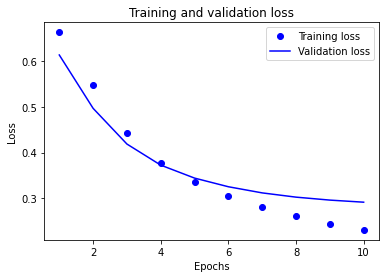

In [29]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

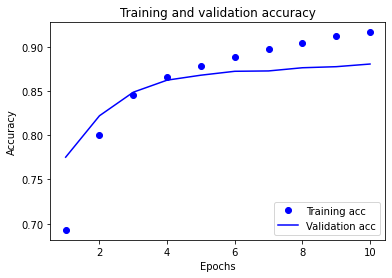

In [30]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the [EarlyStopping callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping?version=nightly).

## Export the model

In the code above, you applied the `TextVectorization` layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the `TextVectorization` layer inside your model. To do so, you can create a new model using the weights you just trained.

In [31]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

  1/782 [..............................] - ETA: 0s - loss: 0.3072 - accuracy: 0.8438

 13/782 [..............................] - ETA: 3s - loss: 0.2991 - accuracy: 0.8750

 25/782 [..............................] - ETA: 3s - loss: 0.3041 - accuracy: 0.8700

 37/782 [>.............................] - ETA: 3s - loss: 0.2964 - accuracy: 0.8775

 49/782 [>.............................] - ETA: 3s - loss: 0.3152 - accuracy: 0.8699

 61/782 [=>............................] - ETA: 3s - loss: 0.3167 - accuracy: 0.8653

 73/782 [=>............................] - ETA: 3s - loss: 0.3054 - accuracy: 0.8703

 85/782 [==>...........................] - ETA: 3s - loss: 0.3059 - accuracy: 0.8706

 97/782 [==>...........................] - ETA: 2s - loss: 0.3030 - accuracy: 0.8724

108/782 [===>..........................] - ETA: 2s - loss: 0.2991 - accuracy: 0.8747

119/782 [===>..........................] - ETA: 2s - loss: 0.3002 - accuracy: 0.8745

131/782 [====>.........................] - ETA: 2s - loss: 0.2978 - accuracy: 0.8757

142/782 [====>.........................] - ETA: 2s - loss: 0.2968 - accuracy: 0.8759

154/782 [====>.........................] - ETA: 2s - loss: 0.2984 - accuracy: 0.8768

165/782 [=====>........................] - ETA: 2s - loss: 0.2963 - accuracy: 0.8782

176/782 [=====>........................] - ETA: 2s - loss: 0.2939 - accuracy: 0.8796

187/782 [======>.......................] - ETA: 2s - loss: 0.2947 - accuracy: 0.8793

199/782 [======>.......................] - ETA: 2s - loss: 0.2921 - accuracy: 0.8813

211/782 [=======>......................] - ETA: 2s - loss: 0.2949 - accuracy: 0.8799

222/782 [=======>......................] - ETA: 2s - loss: 0.2942 - accuracy: 0.8812

234/782 [=======>......................] - ETA: 2s - loss: 0.2943 - accuracy: 0.8814

246/782 [========>.....................] - ETA: 2s - loss: 0.2962 - accuracy: 0.8807

258/782 [========>.....................] - ETA: 2s - loss: 0.2974 - accuracy: 0.8800

270/782 [=========>....................] - ETA: 2s - loss: 0.3006 - accuracy: 0.8781

281/782 [=========>....................] - ETA: 2s - loss: 0.3017 - accuracy: 0.8773

293/782 [==========>...................] - ETA: 2s - loss: 0.3019 - accuracy: 0.8773

304/782 [==========>...................] - ETA: 2s - loss: 0.3021 - accuracy: 0.8771

316/782 [===========>..................] - ETA: 2s - loss: 0.3019 - accuracy: 0.8773

327/782 [===========>..................] - ETA: 2s - loss: 0.3031 - accuracy: 0.8766

339/782 [============>.................] - ETA: 1s - loss: 0.3030 - accuracy: 0.8766

351/782 [============>.................] - ETA: 1s - loss: 0.3046 - accuracy: 0.8762

363/782 [============>.................] - ETA: 1s - loss: 0.3044 - accuracy: 0.8766

375/782 [=============>................] - ETA: 1s - loss: 0.3046 - accuracy: 0.8769

387/782 [=============>................] - ETA: 1s - loss: 0.3038 - accuracy: 0.8775

399/782 [==============>...............] - ETA: 1s - loss: 0.3045 - accuracy: 0.8780

411/782 [==============>...............] - ETA: 1s - loss: 0.3047 - accuracy: 0.8777

423/782 [===============>..............] - ETA: 1s - loss: 0.3043 - accuracy: 0.8780

435/782 [===============>..............] - ETA: 1s - loss: 0.3045 - accuracy: 0.8779

447/782 [================>.............] - ETA: 1s - loss: 0.3053 - accuracy: 0.8781

458/782 [================>.............] - ETA: 1s - loss: 0.3059 - accuracy: 0.8777

469/782 [================>.............] - ETA: 1s - loss: 0.3061 - accuracy: 0.8773

481/782 [=================>............] - ETA: 1s - loss: 0.3063 - accuracy: 0.8768

492/782 [=================>............] - ETA: 1s - loss: 0.3072 - accuracy: 0.8758

504/782 [==================>...........] - ETA: 1s - loss: 0.3064 - accuracy: 0.8758

516/782 [==================>...........] - ETA: 1s - loss: 0.3064 - accuracy: 0.8755

527/782 [===================>..........] - ETA: 1s - loss: 0.3053 - accuracy: 0.8761

538/782 [===================>..........] - ETA: 1s - loss: 0.3064 - accuracy: 0.8756

550/782 [====================>.........] - ETA: 1s - loss: 0.3059 - accuracy: 0.8759

562/782 [====================>.........] - ETA: 0s - loss: 0.3070 - accuracy: 0.8759

573/782 [====================>.........] - ETA: 0s - loss: 0.3078 - accuracy: 0.8757

584/782 [=====================>........] - ETA: 0s - loss: 0.3074 - accuracy: 0.8761

595/782 [=====================>........] - ETA: 0s - loss: 0.3071 - accuracy: 0.8762

607/782 [======================>.......] - ETA: 0s - loss: 0.3074 - accuracy: 0.8761

619/782 [======================>.......] - ETA: 0s - loss: 0.3074 - accuracy: 0.8761

631/782 [=======================>......] - ETA: 0s - loss: 0.3074 - accuracy: 0.8760

643/782 [=======================>......] - ETA: 0s - loss: 0.3083 - accuracy: 0.8761

655/782 [========================>.....] - ETA: 0s - loss: 0.3088 - accuracy: 0.8758

667/782 [========================>.....] - ETA: 0s - loss: 0.3099 - accuracy: 0.8752

679/782 [=========================>....] - ETA: 0s - loss: 0.3110 - accuracy: 0.8746

691/782 [=========================>....] - ETA: 0s - loss: 0.3107 - accuracy: 0.8749

703/782 [=========================>....] - ETA: 0s - loss: 0.3108 - accuracy: 0.8748

714/782 [==========================>...] - ETA: 0s - loss: 0.3106 - accuracy: 0.8746

726/782 [==========================>...] - ETA: 0s - loss: 0.3097 - accuracy: 0.8748

738/782 [===========================>..] - ETA: 0s - loss: 0.3094 - accuracy: 0.8749

750/782 [===========================>..] - ETA: 0s - loss: 0.3093 - accuracy: 0.8749

762/782 [============================>.] - ETA: 0s - loss: 0.3092 - accuracy: 0.8747

774/782 [============================>.] - ETA: 0s - loss: 0.3097 - accuracy: 0.8743

782/782 [==============================] - 3s 4ms/step - loss: 0.3097 - accuracy: 0.8740


0.8740400075912476


Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew).

There is a performance difference to keep in mind when choosing where to apply your TextVectorization layer. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment.

Visit this [tutorial](https://www.tensorflow.org/tutorials/keras/save_and_load) to learn more about saving models.

## Exercise: multiclass classification on Stack Overflow questions

This tutorial showed how to train a binary classifier from scratch on the IMDB dataset. As an exercise, you can modify this notebook to train a multiclass classifier to predict the tag of a programming question on [Stack Overflow](http://stackoverflow.com/).

We have prepared a [dataset](http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) for you to use containing the body of several thousand programming questions (for example, "How can sort a dictionary by value in Python?") posted to Stack Overflow. Each of these is labeled with exactly one tag (either Python, CSharp, JavaScript, or Java). Your task is to take a question as input, and predict the appropriate tag, in this case, Python. 

The dataset you will work with contains several thousand questions extracted from the much larger public Stack Overflow dataset on [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow), which contains more than 17 million posts.

After downloading the dataset, you will find it has a similar directory structure to the IMDB dataset you worked with previously:

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

Note: to increase the difficulty of the classification problem, we have replaced any occurences of the words Python, CSharp, JavaScript, or Java in the programming questions with the word *blank* (as many questions contain the language they're about). 

To complete this exercise, you should modify this notebook to work with the Stack Overflow dataset by making the following modifications:

1. At the top of your notebook, update the code that downloads the IMDB dataset with code to download the [Stack Overflow dataset](http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) we have prepreared. As the Stack Overflow dataset has a similar directory structure, you will not need to make many modifications. 

1. Modify the last layer of your model to read `Dense(4)`, as there are now four output classes.

1. When you compile your model, change the loss to [SparseCategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy?version=nightly). This is the correct loss function to use for a multiclass classification problem, when the labels for each class are integers (in our case, they can be 0, *1*, *2*, or *3*).

1. Once these changes are complete, you will be able to train a multiclass classifier. 

If you get stuck, you can find a solution [here](https://github.com/tensorflow/examples/blob/master/community/en/text_classification_solution.ipynb).


## Learning more

This tutorial introduced text classification from scratch. To learn more about the text classification workflow in general, we recommend reading [this guide](https://developers.google.com/machine-learning/guides/text-classification/) from Google Developers.
